# Load the data 

In [ ]:
!python -m wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py
!python -m wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
!python -m wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
!python -m wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py
!python -m wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py

In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/zips/test2017.zip

!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

In [1]:
!pip install fiftyone

  Obtaining dependency information for fiftyone from https://files.pythonhosted.org/packages/0e/1f/062e3087fa672a8324c969521670e5475edecb8005ab6c9f872a274db784/fiftyone-0.21.4-py3-none-any.whl.metadata
  Using cached fiftyone-0.21.4-py3-none-any.whl.metadata (12 kB)
  Obtaining dependency information for boto3 from https://files.pythonhosted.org/packages/51/85/48dc639c57cb1a25b1f7b3022d2ab982fd97156715cb11f50102cb5c551f/boto3-1.28.19-py3-none-any.whl.metadata
  Using cached boto3-1.28.19-py3-none-any.whl.metadata (6.6 kB)
  Using cached sse_starlette-0.10.3-py3-none-any.whl (8.0 kB)
  Using cached universal_analytics_python3-1.1.1-py3-none-any.whl (10 kB)
  Obtaining dependency information for fiftyone-brain<0.14,>=0.13 from https://files.pythonhosted.org/packages/0a/30/1f9578c884d267a8205d73143310d0ac4301b82a2b47ac61f382bb2c4c28/fiftyone_brain-0.13.0-py3-none-any.whl.metadata
  Using cached fiftyone_brain-0.13.0-py3-none-any.whl.metadata (12 kB)
  Obtaining dependency information for 

In [1]:
import os
import json
import torch

import torchvision

from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import numpy as np

from pycocotools.coco import COCO
from PIL import Image, ImageDraw
from coco_utils import get_coco_api_from_dataset
from pycocotools.cocoeval import COCOeval
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import fiftyone as fo
import fiftyone.zoo as foz
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
# Load COCO dataset and annotations
root_dir = r'C:\Users\USER\fiftyone\coco-2017'
train_annotation_file = r'C:\Users\USER\fiftyone\coco-2017\train\labels.json'
val_annotation_file = r'C:\Users\USER\fiftyone\coco-2017\validation\labels.json'

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
# Custom COCO dataset class for person detection
class CustomCOCODataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation_file, mode='train', transform=None):
        self.root = root
        self.transform = transform
        self.mode = 'train' if mode == 'train' else 'validation'
        self.coco = COCO(annotation_file)
        self.person_ids = self.coco.getImgIds(catIds=self.coco.getCatIds(catNms=['person']))

    def __len__(self):
        return len(self.person_ids)

    def __getitem__(self, idx):
        img_id = self.person_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_filename = os.path.join(self.root, f'{self.mode}\data', img_info['file_name'])
        image = Image.open(img_filename).convert("RGB")

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        annotations = self.coco.loadAnns(ann_ids)

        boxes = []
        labels = []
        for ann in annotations:
            if ann['category_id'] == 1:  # Check if the category is "person"
                bbox = ann['bbox']
                x, y, w, h = bbox
                x1, y1, x2, y2 = x, y, x+w, y+h
                boxes.append([x1, y1, x2, y2])
                labels.append(1)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([img_id]),
            'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
            'iscrowd': torch.zeros((len(boxes),), dtype=torch.int64)
        }

        if self.transform is not None:
            image, target = self.transform(image, target)

        return image, target

In [5]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))

    return T.Compose(transforms)

def collate_fn(batch):
    return tuple(zip(*batch))

def custom_collate_fn(batch):
    images, targets = zip(*batch)
    images = list(images)
    targets = list(targets)

    for i, target in enumerate(targets):
        target['image_id'] = torch.tensor([i])

    return images, targets

In [14]:
train_dataset = CustomCOCODataset(root_dir, train_annotation_file, 'train', transform=get_transform(train=True))
val_dataset = CustomCOCODataset(root_dir, val_annotation_file, mode='validation', transform=get_transform(train=False))

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.61s)
creating index...
index created!
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [15]:
len(train_dataset), len(val_loader)

(3000, 500)

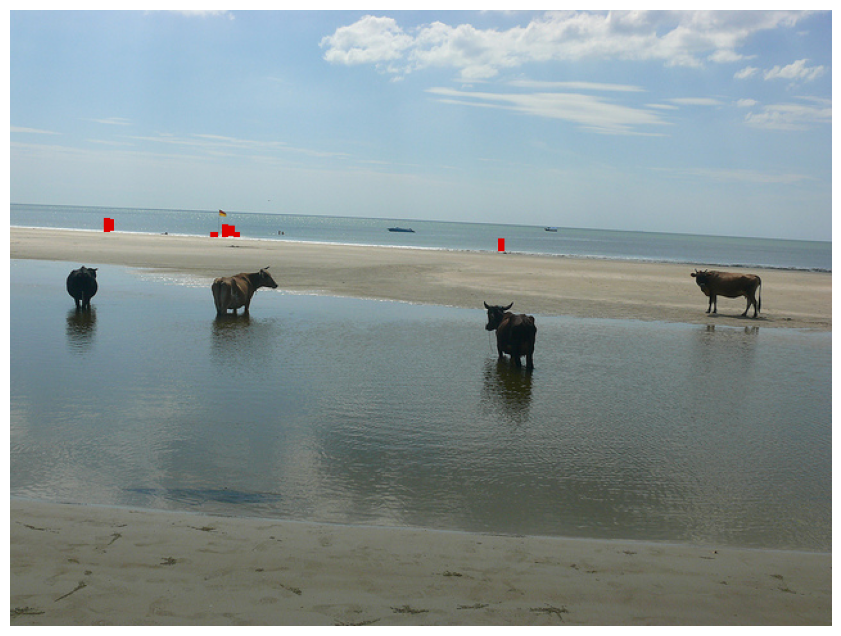

In [8]:
# Loop through the DataLoader to access each batch
for images, targets in train_loader:
    # Move images and targets to the device (e.g., GPU)
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    # Accessing the first image and target in the batch
    boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[0].permute(1, 2, 0).cpu().numpy()

    # Convert numpy array to PIL Image
    sample_img = Image.fromarray((sample * 255).astype(np.uint8))

    # Create a draw object
    draw = ImageDraw.Draw(sample_img)

    for box in boxes:
        # Draw rectangle on the image
        draw.rectangle([box[0], box[1], box[2], box[3]], outline=(220, 0, 0), width=3)

    plt.figure(figsize=(16, 8))
    plt.imshow(sample_img)
    plt.axis('off')
    plt.show()

    # Exit the loop after processing the first batch
    break

In [9]:
images, targets = next(iter(train_loader))

In [10]:
images[0].shape

torch.Size([3, 375, 500])

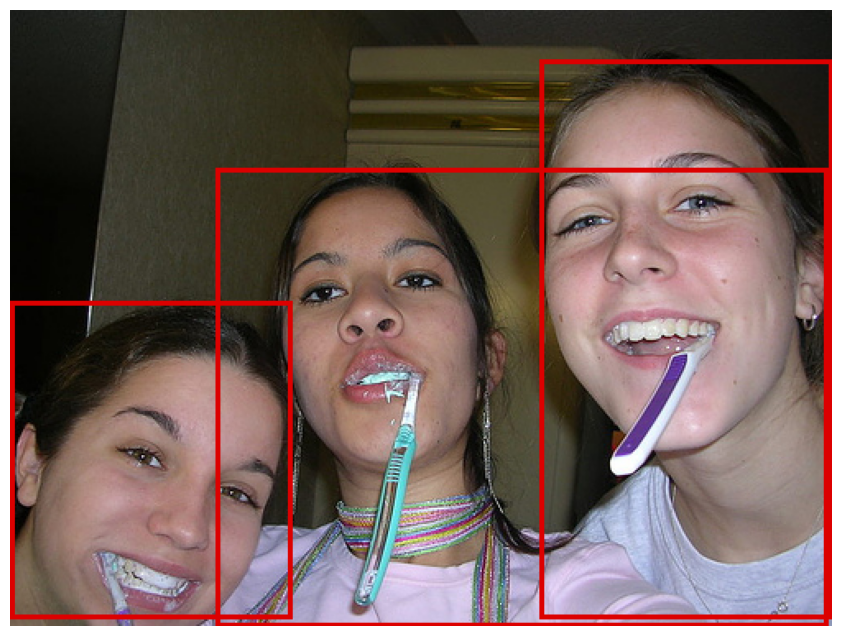

In [11]:
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0].permute(1, 2, 0).cpu().numpy()

# Convert numpy array to PIL Image
sample_img = Image.fromarray((sample * 255).astype(np.uint8))

# Create a draw object
draw = ImageDraw.Draw(sample_img)

for box in boxes:
    # Draw rectangle on the image
    draw.rectangle([box[0], box[1], box[2], box[3]], outline=(220, 0, 0), width=3)

plt.figure(figsize=(16, 8))
plt.imshow(sample_img)
plt.axis('off')
plt.show()


# Modeling

In [12]:
# Load pre-trained VGG16 backbone
# backbone = torchvision.models.vgg16(weights="DEFAULT").features #VGG16
# backbone.out_channels = 512

# Load pre-trained VGG16 backbone
# backbone = torchvision.models.resnet50(pretrained=True)
# backbone = torch.nn.Sequential(*list(backbone.children())[:-2])
# backbone.out_channels = 2048

backbone = torchvision.models.mobilenet_v2(pretrained=True).features
backbone.out_channels = 1280

In [13]:
# Load pretrained model
# vgg16 = torchvision.models.vgg16(pretrained=True)
# backbone = torch.nn.Sequential(*list(vgg16.features.children())[:-1])

# Create anchor generator
# anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
# aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
# anchor_generator = AnchorGenerator(sizes=anchor_sizes, aspect_ratios=aspect_ratios)
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# Create ROI pooler
roi_pooler = MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)

# Number of classes (including background class)
num_classes = 2

# Create Faster R-CNN model
model = FasterRCNN(backbone, num_classes=num_classes, rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)

In [14]:
# Define optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Define the loss functions separately for classification and regression
classification_loss_fn = torch.nn.CrossEntropyLoss()
regression_loss_fn = torch.nn.SmoothL1Loss()

In [15]:
for param in model.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [16]:
model.state_dict()

OrderedDict([('backbone.0.0.weight',
              tensor([[[[ 1.3185e-02, -4.3213e-03,  1.4823e-02],
                        [ 3.2780e-02, -2.5385e-02,  6.8572e-03],
                        [ 1.0549e-02, -3.7347e-02, -1.4727e-02]],
              
                       [[ 7.9917e-03, -5.9146e-03,  1.5076e-02],
                        [ 1.9999e-02, -3.2863e-02, -2.0859e-03],
                        [ 1.1350e-02, -3.2956e-02, -7.8733e-03]],
              
                       [[-2.5234e-02, -2.0167e-02, -9.9620e-03],
                        [-1.1213e-02, -2.9266e-02, -1.5218e-02],
                        [-2.6531e-02, -3.3449e-02, -2.4215e-02]]],
              
              
                      [[[-6.3694e-02, -2.1300e-02,  2.1416e-02],
                        [ 1.3037e-01,  3.7967e-01,  4.1983e-02],
                        [-1.8793e-01, -2.7921e-01, -3.8335e-02]],
              
                       [[-6.7306e-02,  5.3145e-02,  1.8353e-03],
                        [ 2.6662e-01, 

In [ ]:
# # Train the model
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# model.to(device)
# num_epochs = 10
# for epoch in range(num_epochs):
#     model.train()
#     for images, targets in tqdm(train_loader):
#         images = [image.to(device) for image in images]
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#         # Forward pass
#         outputs = model(images, targets)
#         classification_loss = classification_loss_fn(outputs['classification'], targets['labels'])
#         regression_loss = regression_loss_fn(outputs['regression'], targets['boxes'])
        
#         # Compute total loss (sum of classification loss and regression loss)
#         loss = classification_loss + regression_loss

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')
#     lr_scheduler.step()

# # Save the trained model
# torch.save(model.state_dict(), 'person_detection_model.pth')

In [17]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        for p in prediction:
          boxes = p["boxes"]
          boxes = convert_to_xywh(boxes).tolist()
          scores = p["scores"].tolist()
          labels = p["labels"].tolist()

          coco_results.extend(
              [
                  {
                      "image_id": original_id,
                      "category_id": labels[k],
                      "bbox": box,
                      "score": scores[k],
                  }
                  for k, box in enumerate(boxes)
              ]
          )
    return coco_results

def evaluate(model, dataset_test, device):
    cpu_device = torch.device("cpu")
    preds = []
    targets = []
    model.eval()
    for img, target in dataset_test:
        with torch.no_grad():
            pred = model([img.to(device)])
            pred = [{k: v.to(cpu_device) for k, v in t.items()} for t in pred]
            preds.append(pred)
            targets.append(target)
    with tqdm(total=len(dataset_test), desc='Evaluating') as pbar:
        for img, target in dataset_test:
            with torch.no_grad():
                pred = model([img.to(device)])
                pred = [{k: v.to(cpu_device) for k, v in t.items()} for t in pred]
                preds.append(pred)
                targets.append(target)
            pbar.update(1)

    res = {target["image_id"].tolist()[0]: output for target, output in zip(targets, preds)}
    res = prepare_for_coco_detection(res)

    coco_gt = get_coco_api_from_dataset(dataset_test)
    coco_dt = coco_gt.loadRes(res)
    coco_evaluator = COCOeval(coco_gt, coco_dt, 'bbox')
    coco_evaluator.evaluate()
    coco_evaluator.accumulate()
    coco_evaluator.summarize()


In [18]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(


In [8]:
def checkpoint(model, optimizer, epoch):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    path = r'C:\Users\USER\Documents\2023\AI\2. Person Tracking\V2 (mobilenet_v2)\model'
    filename = 'person_detection_model'
    full_path = f'{path}\\{filename}-epoch-{epoch}.pth'
    torch.save(checkpoint, full_path)

In [20]:
from engine import train_one_epoch
import utils
def train():
    # let's train it for 10 epochs
    num_epochs = 10
    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # Save the trained model
        checkpoint(model, optimizer, epoch)
    print("\nSelesai")

In [21]:
train()

C:\Users\USER\anaconda3\envs\object_detection\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [   0/1500]  eta: 2:02:30  lr: 0.000002  loss: 1.4095 (1.4095)  loss_classifier: 0.6566 (0.6566)  loss_box_reg: 0.0165 (0.0165)  loss_objectness: 0.7068 (0.7068)  loss_rpn_box_reg: 0.0295 (0.0295)  time: 4.9005  data: 0.0143  max mem: 4022
Epoch: [0]  [  10/1500]  eta: 0:15:44  lr: 0.000012  loss: 1.4855 (1.4834)  loss_classifier: 0.6517 (0.6494)  loss_box_reg: 0.0414 (0.0410)  loss_objectness: 0.7011 (0.6998)  loss_rpn_box_reg: 0.0852 (0.0932)  time: 0.6341  data: 0.0126  max mem: 5677
Epoch: [0]  [  20/1500]  eta: 0:10:53  lr: 0.000022  loss: 1.4855 (1.4812)  loss_classifier: 0.6195 (0.6133)  loss_box_reg: 0.0414 (0.0511)  loss_objectness: 0.6981 (0.6982)  loss_rpn_box_reg: 0.0872 (0.1185)  time: 0.2188  data: 0.0120  max mem: 6622
Epoch: [0]  [  30/1500]  eta: 0:08:56  lr: 0.000032  loss: 1.3083 (1.3992)  loss_classifier: 0.4950 (0.5504)  loss_box_reg: 0.0269 (0.0425)  loss_objectness: 0.6910 (0.6949)  loss_rpn_box_reg: 0.0807 (0.1114)  time: 0.2166  data: 0.0114  max me

Epoch: [0]  [ 330/1500]  eta: 0:03:56  lr: 0.000332  loss: 0.4228 (0.7822)  loss_classifier: 0.1152 (0.1998)  loss_box_reg: 0.0745 (0.0748)  loss_objectness: 0.2079 (0.4235)  loss_rpn_box_reg: 0.0475 (0.0841)  time: 0.1881  data: 0.0116  max mem: 6622
Epoch: [0]  [ 340/1500]  eta: 0:03:53  lr: 0.000342  loss: 0.4048 (0.7707)  loss_classifier: 0.1152 (0.1970)  loss_box_reg: 0.0711 (0.0745)  loss_objectness: 0.1770 (0.4164)  loss_rpn_box_reg: 0.0308 (0.0827)  time: 0.1871  data: 0.0115  max mem: 6622
Epoch: [0]  [ 350/1500]  eta: 0:03:51  lr: 0.000352  loss: 0.3923 (0.7644)  loss_classifier: 0.1131 (0.1962)  loss_box_reg: 0.0731 (0.0759)  loss_objectness: 0.1590 (0.4105)  loss_rpn_box_reg: 0.0307 (0.0817)  time: 0.1896  data: 0.0112  max mem: 6622
Epoch: [0]  [ 360/1500]  eta: 0:03:48  lr: 0.000362  loss: 0.5228 (0.7563)  loss_classifier: 0.1264 (0.1942)  loss_box_reg: 0.0855 (0.0758)  loss_objectness: 0.1890 (0.4051)  loss_rpn_box_reg: 0.0350 (0.0812)  time: 0.1866  data: 0.0117  max me

Epoch: [0]  [ 660/1500]  eta: 0:02:41  lr: 0.000661  loss: 0.4847 (0.6483)  loss_classifier: 0.1529 (0.1774)  loss_box_reg: 0.1031 (0.0960)  loss_objectness: 0.1547 (0.3011)  loss_rpn_box_reg: 0.0395 (0.0739)  time: 0.1911  data: 0.0109  max mem: 6622
Epoch: [0]  [ 670/1500]  eta: 0:02:39  lr: 0.000671  loss: 0.4501 (0.6479)  loss_classifier: 0.1529 (0.1774)  loss_box_reg: 0.1031 (0.0968)  loss_objectness: 0.1441 (0.2996)  loss_rpn_box_reg: 0.0439 (0.0741)  time: 0.1886  data: 0.0110  max mem: 6622
Epoch: [0]  [ 680/1500]  eta: 0:02:37  lr: 0.000681  loss: 0.4889 (0.6444)  loss_classifier: 0.1600 (0.1768)  loss_box_reg: 0.1082 (0.0970)  loss_objectness: 0.1441 (0.2970)  loss_rpn_box_reg: 0.0439 (0.0736)  time: 0.1853  data: 0.0109  max mem: 6622
Epoch: [0]  [ 690/1500]  eta: 0:02:35  lr: 0.000691  loss: 0.4333 (0.6434)  loss_classifier: 0.1373 (0.1766)  loss_box_reg: 0.1082 (0.0975)  loss_objectness: 0.1308 (0.2957)  loss_rpn_box_reg: 0.0332 (0.0736)  time: 0.1860  data: 0.0113  max me

Epoch: [0]  [ 990/1500]  eta: 0:01:37  lr: 0.000991  loss: 0.4349 (0.5858)  loss_classifier: 0.1408 (0.1632)  loss_box_reg: 0.1282 (0.1045)  loss_objectness: 0.1196 (0.2485)  loss_rpn_box_reg: 0.0409 (0.0696)  time: 0.1896  data: 0.0113  max mem: 6622
Epoch: [0]  [1000/1500]  eta: 0:01:35  lr: 0.001000  loss: 0.3251 (0.5833)  loss_classifier: 0.1086 (0.1626)  loss_box_reg: 0.1004 (0.1044)  loss_objectness: 0.0929 (0.2471)  loss_rpn_box_reg: 0.0237 (0.0692)  time: 0.1869  data: 0.0116  max mem: 6622
Epoch: [0]  [1010/1500]  eta: 0:01:33  lr: 0.001000  loss: 0.3441 (0.5824)  loss_classifier: 0.1152 (0.1625)  loss_box_reg: 0.0874 (0.1048)  loss_objectness: 0.0969 (0.2460)  loss_rpn_box_reg: 0.0315 (0.0692)  time: 0.1838  data: 0.0122  max mem: 6622
Epoch: [0]  [1020/1500]  eta: 0:01:31  lr: 0.001000  loss: 0.4152 (0.5809)  loss_classifier: 0.1240 (0.1620)  loss_box_reg: 0.0999 (0.1048)  loss_objectness: 0.0956 (0.2448)  loss_rpn_box_reg: 0.0441 (0.0693)  time: 0.1825  data: 0.0115  max me

Epoch: [0]  [1320/1500]  eta: 0:00:34  lr: 0.001000  loss: 0.3574 (0.5507)  loss_classifier: 0.1016 (0.1554)  loss_box_reg: 0.1195 (0.1092)  loss_objectness: 0.0968 (0.2193)  loss_rpn_box_reg: 0.0219 (0.0668)  time: 0.1854  data: 0.0107  max mem: 6622
Epoch: [0]  [1330/1500]  eta: 0:00:32  lr: 0.001000  loss: 0.3101 (0.5497)  loss_classifier: 0.0844 (0.1550)  loss_box_reg: 0.0865 (0.1091)  loss_objectness: 0.0948 (0.2186)  loss_rpn_box_reg: 0.0181 (0.0670)  time: 0.1848  data: 0.0109  max mem: 6622
Epoch: [0]  [1340/1500]  eta: 0:00:30  lr: 0.001000  loss: 0.3113 (0.5485)  loss_classifier: 0.0958 (0.1548)  loss_box_reg: 0.0973 (0.1093)  loss_objectness: 0.0822 (0.2176)  loss_rpn_box_reg: 0.0335 (0.0668)  time: 0.1863  data: 0.0113  max mem: 6622
Epoch: [0]  [1350/1500]  eta: 0:00:28  lr: 0.001000  loss: 0.4076 (0.5478)  loss_classifier: 0.1249 (0.1547)  loss_box_reg: 0.1277 (0.1095)  loss_objectness: 0.0918 (0.2169)  loss_rpn_box_reg: 0.0335 (0.0667)  time: 0.1881  data: 0.0116  max me

Epoch: [1]  [ 140/1500]  eta: 0:04:14  lr: 0.001000  loss: 0.3963 (0.4039)  loss_classifier: 0.1193 (0.1207)  loss_box_reg: 0.1173 (0.1163)  loss_objectness: 0.0932 (0.1065)  loss_rpn_box_reg: 0.0420 (0.0603)  time: 0.1836  data: 0.0093  max mem: 6622
Epoch: [1]  [ 150/1500]  eta: 0:04:12  lr: 0.001000  loss: 0.3565 (0.4036)  loss_classifier: 0.1083 (0.1195)  loss_box_reg: 0.1300 (0.1162)  loss_objectness: 0.0929 (0.1077)  loss_rpn_box_reg: 0.0249 (0.0603)  time: 0.1868  data: 0.0094  max mem: 6622
Epoch: [1]  [ 160/1500]  eta: 0:04:11  lr: 0.001000  loss: 0.3344 (0.4093)  loss_classifier: 0.0977 (0.1208)  loss_box_reg: 0.0990 (0.1175)  loss_objectness: 0.0777 (0.1093)  loss_rpn_box_reg: 0.0367 (0.0617)  time: 0.1921  data: 0.0088  max mem: 6622
Epoch: [1]  [ 170/1500]  eta: 0:04:08  lr: 0.001000  loss: 0.3962 (0.4161)  loss_classifier: 0.1373 (0.1232)  loss_box_reg: 0.1367 (0.1210)  loss_objectness: 0.1044 (0.1103)  loss_rpn_box_reg: 0.0446 (0.0617)  time: 0.1849  data: 0.0089  max me

Epoch: [1]  [ 470/1500]  eta: 0:03:09  lr: 0.001000  loss: 0.3287 (0.4383)  loss_classifier: 0.1153 (0.1316)  loss_box_reg: 0.0985 (0.1340)  loss_objectness: 0.0915 (0.1132)  loss_rpn_box_reg: 0.0228 (0.0595)  time: 0.1792  data: 0.0096  max mem: 6677
Epoch: [1]  [ 480/1500]  eta: 0:03:08  lr: 0.001000  loss: 0.3287 (0.4366)  loss_classifier: 0.1153 (0.1313)  loss_box_reg: 0.0985 (0.1338)  loss_objectness: 0.0765 (0.1125)  loss_rpn_box_reg: 0.0228 (0.0589)  time: 0.1856  data: 0.0094  max mem: 6677
Epoch: [1]  [ 490/1500]  eta: 0:03:06  lr: 0.001000  loss: 0.3962 (0.4373)  loss_classifier: 0.1299 (0.1317)  loss_box_reg: 0.1118 (0.1342)  loss_objectness: 0.0803 (0.1128)  loss_rpn_box_reg: 0.0245 (0.0586)  time: 0.1825  data: 0.0088  max mem: 6677
Epoch: [1]  [ 500/1500]  eta: 0:03:04  lr: 0.001000  loss: 0.3834 (0.4353)  loss_classifier: 0.1106 (0.1311)  loss_box_reg: 0.1118 (0.1335)  loss_objectness: 0.0803 (0.1124)  loss_rpn_box_reg: 0.0252 (0.0583)  time: 0.1817  data: 0.0085  max me

Epoch: [1]  [ 800/1500]  eta: 0:02:09  lr: 0.001000  loss: 0.3076 (0.4337)  loss_classifier: 0.0877 (0.1317)  loss_box_reg: 0.0733 (0.1351)  loss_objectness: 0.0988 (0.1101)  loss_rpn_box_reg: 0.0209 (0.0568)  time: 0.1859  data: 0.0094  max mem: 6677
Epoch: [1]  [ 810/1500]  eta: 0:02:07  lr: 0.001000  loss: 0.3338 (0.4334)  loss_classifier: 0.0944 (0.1314)  loss_box_reg: 0.0844 (0.1348)  loss_objectness: 0.0740 (0.1106)  loss_rpn_box_reg: 0.0257 (0.0566)  time: 0.1913  data: 0.0091  max mem: 6677
Epoch: [1]  [ 820/1500]  eta: 0:02:05  lr: 0.001000  loss: 0.3338 (0.4330)  loss_classifier: 0.0988 (0.1313)  loss_box_reg: 0.1128 (0.1348)  loss_objectness: 0.0740 (0.1104)  loss_rpn_box_reg: 0.0295 (0.0565)  time: 0.1872  data: 0.0089  max mem: 6677
Epoch: [1]  [ 830/1500]  eta: 0:02:03  lr: 0.001000  loss: 0.3421 (0.4328)  loss_classifier: 0.1259 (0.1314)  loss_box_reg: 0.1278 (0.1350)  loss_objectness: 0.0742 (0.1099)  loss_rpn_box_reg: 0.0319 (0.0565)  time: 0.1853  data: 0.0086  max me

Epoch: [1]  [1130/1500]  eta: 0:01:08  lr: 0.001000  loss: 0.4595 (0.4255)  loss_classifier: 0.1186 (0.1300)  loss_box_reg: 0.1033 (0.1350)  loss_objectness: 0.0953 (0.1052)  loss_rpn_box_reg: 0.0522 (0.0553)  time: 0.1794  data: 0.0090  max mem: 6677
Epoch: [1]  [1140/1500]  eta: 0:01:06  lr: 0.001000  loss: 0.3827 (0.4254)  loss_classifier: 0.1349 (0.1300)  loss_box_reg: 0.1148 (0.1350)  loss_objectness: 0.0915 (0.1051)  loss_rpn_box_reg: 0.0384 (0.0553)  time: 0.1774  data: 0.0089  max mem: 6677
Epoch: [1]  [1150/1500]  eta: 0:01:04  lr: 0.001000  loss: 0.3726 (0.4259)  loss_classifier: 0.1321 (0.1302)  loss_box_reg: 0.1205 (0.1352)  loss_objectness: 0.0704 (0.1052)  loss_rpn_box_reg: 0.0346 (0.0554)  time: 0.1824  data: 0.0084  max mem: 6677
Epoch: [1]  [1160/1500]  eta: 0:01:02  lr: 0.001000  loss: 0.4364 (0.4262)  loss_classifier: 0.1394 (0.1302)  loss_box_reg: 0.1206 (0.1354)  loss_objectness: 0.0812 (0.1053)  loss_rpn_box_reg: 0.0353 (0.0554)  time: 0.1824  data: 0.0084  max me

Epoch: [1]  [1460/1500]  eta: 0:00:07  lr: 0.001000  loss: 0.3682 (0.4270)  loss_classifier: 0.1158 (0.1303)  loss_box_reg: 0.1113 (0.1369)  loss_objectness: 0.0839 (0.1045)  loss_rpn_box_reg: 0.0268 (0.0553)  time: 0.1799  data: 0.0089  max mem: 6677
Epoch: [1]  [1470/1500]  eta: 0:00:05  lr: 0.001000  loss: 0.4431 (0.4275)  loss_classifier: 0.1365 (0.1304)  loss_box_reg: 0.1403 (0.1371)  loss_objectness: 0.0974 (0.1047)  loss_rpn_box_reg: 0.0381 (0.0553)  time: 0.1720  data: 0.0099  max mem: 6677
Epoch: [1]  [1480/1500]  eta: 0:00:03  lr: 0.001000  loss: 0.4455 (0.4274)  loss_classifier: 0.1147 (0.1304)  loss_box_reg: 0.1339 (0.1372)  loss_objectness: 0.0920 (0.1046)  loss_rpn_box_reg: 0.0401 (0.0552)  time: 0.1738  data: 0.0093  max mem: 6677
Epoch: [1]  [1490/1500]  eta: 0:00:01  lr: 0.001000  loss: 0.3241 (0.4275)  loss_classifier: 0.1050 (0.1304)  loss_box_reg: 0.1121 (0.1372)  loss_objectness: 0.0613 (0.1047)  loss_rpn_box_reg: 0.0300 (0.0553)  time: 0.1879  data: 0.0089  max me

Epoch: [2]  [ 280/1500]  eta: 0:03:42  lr: 0.001000  loss: 0.3406 (0.4177)  loss_classifier: 0.1163 (0.1319)  loss_box_reg: 0.1256 (0.1473)  loss_objectness: 0.0728 (0.0909)  loss_rpn_box_reg: 0.0147 (0.0475)  time: 0.1862  data: 0.0093  max mem: 6677
Epoch: [2]  [ 290/1500]  eta: 0:03:41  lr: 0.001000  loss: 0.2818 (0.4145)  loss_classifier: 0.0931 (0.1305)  loss_box_reg: 0.1046 (0.1456)  loss_objectness: 0.0560 (0.0907)  loss_rpn_box_reg: 0.0218 (0.0478)  time: 0.1897  data: 0.0092  max mem: 6677
Epoch: [2]  [ 300/1500]  eta: 0:03:38  lr: 0.001000  loss: 0.2919 (0.4145)  loss_classifier: 0.0796 (0.1300)  loss_box_reg: 0.0945 (0.1450)  loss_objectness: 0.0714 (0.0912)  loss_rpn_box_reg: 0.0243 (0.0484)  time: 0.1863  data: 0.0087  max mem: 6677
Epoch: [2]  [ 310/1500]  eta: 0:03:36  lr: 0.001000  loss: 0.4114 (0.4140)  loss_classifier: 0.1198 (0.1300)  loss_box_reg: 0.0965 (0.1447)  loss_objectness: 0.0884 (0.0911)  loss_rpn_box_reg: 0.0421 (0.0483)  time: 0.1762  data: 0.0086  max me

Epoch: [2]  [ 610/1500]  eta: 0:02:43  lr: 0.001000  loss: 0.3902 (0.4120)  loss_classifier: 0.1331 (0.1296)  loss_box_reg: 0.1463 (0.1448)  loss_objectness: 0.0614 (0.0885)  loss_rpn_box_reg: 0.0302 (0.0491)  time: 0.1879  data: 0.0088  max mem: 6677
Epoch: [2]  [ 620/1500]  eta: 0:02:42  lr: 0.001000  loss: 0.3223 (0.4118)  loss_classifier: 0.1000 (0.1296)  loss_box_reg: 0.1115 (0.1448)  loss_objectness: 0.0537 (0.0882)  loss_rpn_box_reg: 0.0252 (0.0492)  time: 0.2022  data: 0.0088  max mem: 6802
Epoch: [2]  [ 630/1500]  eta: 0:02:40  lr: 0.001000  loss: 0.3403 (0.4117)  loss_classifier: 0.0898 (0.1293)  loss_box_reg: 0.1077 (0.1445)  loss_objectness: 0.0745 (0.0886)  loss_rpn_box_reg: 0.0253 (0.0494)  time: 0.2029  data: 0.0090  max mem: 6802
Epoch: [2]  [ 640/1500]  eta: 0:02:38  lr: 0.001000  loss: 0.2843 (0.4116)  loss_classifier: 0.0858 (0.1293)  loss_box_reg: 0.1053 (0.1447)  loss_objectness: 0.0745 (0.0884)  loss_rpn_box_reg: 0.0332 (0.0491)  time: 0.1869  data: 0.0091  max me

Epoch: [2]  [ 940/1500]  eta: 0:01:43  lr: 0.001000  loss: 0.3038 (0.4115)  loss_classifier: 0.1006 (0.1295)  loss_box_reg: 0.1125 (0.1464)  loss_objectness: 0.0564 (0.0867)  loss_rpn_box_reg: 0.0165 (0.0489)  time: 0.1789  data: 0.0095  max mem: 6802
Epoch: [2]  [ 950/1500]  eta: 0:01:41  lr: 0.001000  loss: 0.3673 (0.4115)  loss_classifier: 0.1179 (0.1294)  loss_box_reg: 0.1202 (0.1465)  loss_objectness: 0.0553 (0.0867)  loss_rpn_box_reg: 0.0323 (0.0489)  time: 0.1941  data: 0.0093  max mem: 7148
Epoch: [2]  [ 960/1500]  eta: 0:01:39  lr: 0.001000  loss: 0.3746 (0.4119)  loss_classifier: 0.1083 (0.1294)  loss_box_reg: 0.1292 (0.1464)  loss_objectness: 0.0557 (0.0869)  loss_rpn_box_reg: 0.0379 (0.0493)  time: 0.1955  data: 0.0089  max mem: 7148
Epoch: [2]  [ 970/1500]  eta: 0:01:38  lr: 0.001000  loss: 0.3520 (0.4121)  loss_classifier: 0.1083 (0.1295)  loss_box_reg: 0.1292 (0.1466)  loss_objectness: 0.0604 (0.0868)  loss_rpn_box_reg: 0.0240 (0.0491)  time: 0.1800  data: 0.0087  max me

Epoch: [2]  [1270/1500]  eta: 0:00:42  lr: 0.001000  loss: 0.3646 (0.4079)  loss_classifier: 0.0955 (0.1280)  loss_box_reg: 0.1137 (0.1454)  loss_objectness: 0.0647 (0.0859)  loss_rpn_box_reg: 0.0255 (0.0486)  time: 0.1811  data: 0.0091  max mem: 7148
Epoch: [2]  [1280/1500]  eta: 0:00:40  lr: 0.001000  loss: 0.3864 (0.4074)  loss_classifier: 0.1113 (0.1279)  loss_box_reg: 0.1266 (0.1454)  loss_objectness: 0.0504 (0.0856)  loss_rpn_box_reg: 0.0195 (0.0485)  time: 0.1821  data: 0.0092  max mem: 7148
Epoch: [2]  [1290/1500]  eta: 0:00:38  lr: 0.001000  loss: 0.3413 (0.4071)  loss_classifier: 0.1113 (0.1277)  loss_box_reg: 0.1266 (0.1452)  loss_objectness: 0.0484 (0.0857)  loss_rpn_box_reg: 0.0278 (0.0485)  time: 0.1827  data: 0.0088  max mem: 7148
Epoch: [2]  [1300/1500]  eta: 0:00:36  lr: 0.001000  loss: 0.3427 (0.4070)  loss_classifier: 0.1052 (0.1277)  loss_box_reg: 0.1134 (0.1450)  loss_objectness: 0.0552 (0.0857)  loss_rpn_box_reg: 0.0211 (0.0485)  time: 0.1791  data: 0.0088  max me

Epoch: [3]  [  90/1500]  eta: 0:04:23  lr: 0.000100  loss: 0.3037 (0.3865)  loss_classifier: 0.1031 (0.1260)  loss_box_reg: 0.1187 (0.1498)  loss_objectness: 0.0537 (0.0757)  loss_rpn_box_reg: 0.0184 (0.0350)  time: 0.1851  data: 0.0088  max mem: 7148
Epoch: [3]  [ 100/1500]  eta: 0:04:21  lr: 0.000100  loss: 0.4110 (0.3862)  loss_classifier: 0.1292 (0.1260)  loss_box_reg: 0.1480 (0.1503)  loss_objectness: 0.0547 (0.0752)  loss_rpn_box_reg: 0.0252 (0.0346)  time: 0.1898  data: 0.0088  max mem: 7148
Epoch: [3]  [ 110/1500]  eta: 0:04:20  lr: 0.000100  loss: 0.2554 (0.3786)  loss_classifier: 0.0904 (0.1237)  loss_box_reg: 0.0901 (0.1475)  loss_objectness: 0.0533 (0.0739)  loss_rpn_box_reg: 0.0137 (0.0334)  time: 0.1891  data: 0.0089  max mem: 7148
Epoch: [3]  [ 120/1500]  eta: 0:04:18  lr: 0.000100  loss: 0.2741 (0.3816)  loss_classifier: 0.0937 (0.1246)  loss_box_reg: 0.0991 (0.1479)  loss_objectness: 0.0500 (0.0748)  loss_rpn_box_reg: 0.0181 (0.0342)  time: 0.1874  data: 0.0091  max me

Epoch: [3]  [ 420/1500]  eta: 0:03:20  lr: 0.000100  loss: 0.3457 (0.3959)  loss_classifier: 0.1251 (0.1272)  loss_box_reg: 0.1343 (0.1504)  loss_objectness: 0.0645 (0.0767)  loss_rpn_box_reg: 0.0274 (0.0416)  time: 0.1931  data: 0.0096  max mem: 7148
Epoch: [3]  [ 430/1500]  eta: 0:03:18  lr: 0.000100  loss: 0.4187 (0.3947)  loss_classifier: 0.1408 (0.1271)  loss_box_reg: 0.1415 (0.1498)  loss_objectness: 0.0727 (0.0764)  loss_rpn_box_reg: 0.0274 (0.0413)  time: 0.1931  data: 0.0102  max mem: 7148
Epoch: [3]  [ 440/1500]  eta: 0:03:16  lr: 0.000100  loss: 0.3293 (0.3953)  loss_classifier: 0.1092 (0.1272)  loss_box_reg: 0.1377 (0.1502)  loss_objectness: 0.0555 (0.0767)  loss_rpn_box_reg: 0.0294 (0.0413)  time: 0.1856  data: 0.0093  max mem: 7148
Epoch: [3]  [ 450/1500]  eta: 0:03:14  lr: 0.000100  loss: 0.3647 (0.3964)  loss_classifier: 0.1174 (0.1275)  loss_box_reg: 0.1538 (0.1504)  loss_objectness: 0.0698 (0.0766)  loss_rpn_box_reg: 0.0353 (0.0419)  time: 0.1839  data: 0.0090  max me

Epoch: [3]  [ 750/1500]  eta: 0:02:19  lr: 0.000100  loss: 0.3553 (0.3893)  loss_classifier: 0.1152 (0.1257)  loss_box_reg: 0.1344 (0.1499)  loss_objectness: 0.0700 (0.0742)  loss_rpn_box_reg: 0.0267 (0.0395)  time: 0.1909  data: 0.0090  max mem: 7148
Epoch: [3]  [ 760/1500]  eta: 0:02:17  lr: 0.000100  loss: 0.3303 (0.3889)  loss_classifier: 0.1170 (0.1257)  loss_box_reg: 0.1112 (0.1499)  loss_objectness: 0.0631 (0.0739)  loss_rpn_box_reg: 0.0252 (0.0393)  time: 0.1930  data: 0.0089  max mem: 7148
Epoch: [3]  [ 770/1500]  eta: 0:02:15  lr: 0.000100  loss: 0.3212 (0.3894)  loss_classifier: 0.1210 (0.1260)  loss_box_reg: 0.1165 (0.1504)  loss_objectness: 0.0631 (0.0738)  loss_rpn_box_reg: 0.0263 (0.0392)  time: 0.1859  data: 0.0089  max mem: 7148
Epoch: [3]  [ 780/1500]  eta: 0:02:13  lr: 0.000100  loss: 0.3212 (0.3894)  loss_classifier: 0.1130 (0.1260)  loss_box_reg: 0.1165 (0.1503)  loss_objectness: 0.0655 (0.0738)  loss_rpn_box_reg: 0.0284 (0.0393)  time: 0.1822  data: 0.0085  max me

Epoch: [3]  [1080/1500]  eta: 0:01:17  lr: 0.000100  loss: 0.3500 (0.3995)  loss_classifier: 0.1165 (0.1289)  loss_box_reg: 0.1260 (0.1544)  loss_objectness: 0.0591 (0.0760)  loss_rpn_box_reg: 0.0249 (0.0403)  time: 0.1867  data: 0.0086  max mem: 7148
Epoch: [3]  [1090/1500]  eta: 0:01:15  lr: 0.000100  loss: 0.3133 (0.3985)  loss_classifier: 0.0994 (0.1286)  loss_box_reg: 0.1191 (0.1541)  loss_objectness: 0.0495 (0.0757)  loss_rpn_box_reg: 0.0237 (0.0401)  time: 0.1882  data: 0.0086  max mem: 7148
Epoch: [3]  [1100/1500]  eta: 0:01:13  lr: 0.000100  loss: 0.2624 (0.3975)  loss_classifier: 0.0882 (0.1283)  loss_box_reg: 0.0994 (0.1536)  loss_objectness: 0.0383 (0.0755)  loss_rpn_box_reg: 0.0122 (0.0400)  time: 0.1889  data: 0.0091  max mem: 7148
Epoch: [3]  [1110/1500]  eta: 0:01:11  lr: 0.000100  loss: 0.2624 (0.3972)  loss_classifier: 0.0902 (0.1282)  loss_box_reg: 0.0885 (0.1534)  loss_objectness: 0.0507 (0.0756)  loss_rpn_box_reg: 0.0184 (0.0400)  time: 0.1876  data: 0.0096  max me

Epoch: [3]  [1410/1500]  eta: 0:00:16  lr: 0.000100  loss: 0.4059 (0.3898)  loss_classifier: 0.1263 (0.1261)  loss_box_reg: 0.1277 (0.1502)  loss_objectness: 0.0591 (0.0743)  loss_rpn_box_reg: 0.0388 (0.0393)  time: 0.1881  data: 0.0086  max mem: 7148
Epoch: [3]  [1420/1500]  eta: 0:00:14  lr: 0.000100  loss: 0.4551 (0.3901)  loss_classifier: 0.1493 (0.1261)  loss_box_reg: 0.1663 (0.1503)  loss_objectness: 0.0733 (0.0744)  loss_rpn_box_reg: 0.0348 (0.0393)  time: 0.1842  data: 0.0093  max mem: 7148
Epoch: [3]  [1430/1500]  eta: 0:00:12  lr: 0.000100  loss: 0.4612 (0.3909)  loss_classifier: 0.1539 (0.1264)  loss_box_reg: 0.1924 (0.1506)  loss_objectness: 0.0711 (0.0746)  loss_rpn_box_reg: 0.0309 (0.0394)  time: 0.1825  data: 0.0090  max mem: 7148
Epoch: [3]  [1440/1500]  eta: 0:00:11  lr: 0.000100  loss: 0.4454 (0.3912)  loss_classifier: 0.1443 (0.1265)  loss_box_reg: 0.1924 (0.1508)  loss_objectness: 0.0720 (0.0746)  loss_rpn_box_reg: 0.0315 (0.0393)  time: 0.1846  data: 0.0085  max me

Epoch: [4]  [ 230/1500]  eta: 0:03:55  lr: 0.000100  loss: 0.3103 (0.3707)  loss_classifier: 0.1013 (0.1217)  loss_box_reg: 0.1257 (0.1449)  loss_objectness: 0.0468 (0.0689)  loss_rpn_box_reg: 0.0227 (0.0352)  time: 0.1821  data: 0.0092  max mem: 7148
Epoch: [4]  [ 240/1500]  eta: 0:03:53  lr: 0.000100  loss: 0.3688 (0.3735)  loss_classifier: 0.1142 (0.1225)  loss_box_reg: 0.1479 (0.1464)  loss_objectness: 0.0467 (0.0687)  loss_rpn_box_reg: 0.0227 (0.0359)  time: 0.1861  data: 0.0091  max mem: 7148
Epoch: [4]  [ 250/1500]  eta: 0:03:51  lr: 0.000100  loss: 0.3815 (0.3770)  loss_classifier: 0.1160 (0.1229)  loss_box_reg: 0.1149 (0.1467)  loss_objectness: 0.0612 (0.0704)  loss_rpn_box_reg: 0.0265 (0.0369)  time: 0.1827  data: 0.0085  max mem: 7148
Epoch: [4]  [ 260/1500]  eta: 0:03:49  lr: 0.000100  loss: 0.3047 (0.3797)  loss_classifier: 0.1138 (0.1236)  loss_box_reg: 0.1062 (0.1476)  loss_objectness: 0.0594 (0.0713)  loss_rpn_box_reg: 0.0262 (0.0372)  time: 0.1832  data: 0.0085  max me

Epoch: [4]  [ 560/1500]  eta: 0:02:53  lr: 0.000100  loss: 0.3732 (0.3846)  loss_classifier: 0.1329 (0.1241)  loss_box_reg: 0.1166 (0.1485)  loss_objectness: 0.0443 (0.0730)  loss_rpn_box_reg: 0.0258 (0.0389)  time: 0.1837  data: 0.0087  max mem: 7148
Epoch: [4]  [ 570/1500]  eta: 0:02:51  lr: 0.000100  loss: 0.2973 (0.3859)  loss_classifier: 0.1063 (0.1247)  loss_box_reg: 0.1175 (0.1493)  loss_objectness: 0.0401 (0.0730)  loss_rpn_box_reg: 0.0248 (0.0390)  time: 0.1826  data: 0.0087  max mem: 7148
Epoch: [4]  [ 580/1500]  eta: 0:02:50  lr: 0.000100  loss: 0.2955 (0.3871)  loss_classifier: 0.1059 (0.1250)  loss_box_reg: 0.1070 (0.1494)  loss_objectness: 0.0463 (0.0733)  loss_rpn_box_reg: 0.0346 (0.0395)  time: 0.1886  data: 0.0088  max mem: 7148
Epoch: [4]  [ 590/1500]  eta: 0:02:48  lr: 0.000100  loss: 0.2635 (0.3860)  loss_classifier: 0.0840 (0.1246)  loss_box_reg: 0.0854 (0.1491)  loss_objectness: 0.0450 (0.0730)  loss_rpn_box_reg: 0.0280 (0.0393)  time: 0.1928  data: 0.0085  max me

Epoch: [4]  [ 890/1500]  eta: 0:01:52  lr: 0.000100  loss: 0.3217 (0.3900)  loss_classifier: 0.1187 (0.1264)  loss_box_reg: 0.1411 (0.1504)  loss_objectness: 0.0609 (0.0736)  loss_rpn_box_reg: 0.0150 (0.0396)  time: 0.1867  data: 0.0080  max mem: 7148
Epoch: [4]  [ 900/1500]  eta: 0:01:50  lr: 0.000100  loss: 0.3675 (0.3906)  loss_classifier: 0.1389 (0.1266)  loss_box_reg: 0.1797 (0.1507)  loss_objectness: 0.0578 (0.0736)  loss_rpn_box_reg: 0.0178 (0.0396)  time: 0.1851  data: 0.0081  max mem: 7148
Epoch: [4]  [ 910/1500]  eta: 0:01:48  lr: 0.000100  loss: 0.3872 (0.3909)  loss_classifier: 0.1371 (0.1268)  loss_box_reg: 0.1488 (0.1508)  loss_objectness: 0.0545 (0.0735)  loss_rpn_box_reg: 0.0301 (0.0397)  time: 0.1844  data: 0.0084  max mem: 7148
Epoch: [4]  [ 920/1500]  eta: 0:01:46  lr: 0.000100  loss: 0.3049 (0.3901)  loss_classifier: 0.1021 (0.1266)  loss_box_reg: 0.1184 (0.1506)  loss_objectness: 0.0478 (0.0733)  loss_rpn_box_reg: 0.0280 (0.0396)  time: 0.1820  data: 0.0089  max me

Epoch: [4]  [1220/1500]  eta: 0:00:51  lr: 0.000100  loss: 0.2748 (0.3887)  loss_classifier: 0.0881 (0.1260)  loss_box_reg: 0.0921 (0.1505)  loss_objectness: 0.0457 (0.0730)  loss_rpn_box_reg: 0.0162 (0.0392)  time: 0.1838  data: 0.0093  max mem: 7148
Epoch: [4]  [1230/1500]  eta: 0:00:49  lr: 0.000100  loss: 0.3009 (0.3896)  loss_classifier: 0.1044 (0.1263)  loss_box_reg: 0.1233 (0.1512)  loss_objectness: 0.0506 (0.0730)  loss_rpn_box_reg: 0.0164 (0.0392)  time: 0.1839  data: 0.0088  max mem: 7148
Epoch: [4]  [1240/1500]  eta: 0:00:47  lr: 0.000100  loss: 0.4327 (0.3894)  loss_classifier: 0.1162 (0.1262)  loss_box_reg: 0.1193 (0.1511)  loss_objectness: 0.0654 (0.0730)  loss_rpn_box_reg: 0.0239 (0.0392)  time: 0.1836  data: 0.0083  max mem: 7148
Epoch: [4]  [1250/1500]  eta: 0:00:45  lr: 0.000100  loss: 0.2903 (0.3887)  loss_classifier: 0.0933 (0.1259)  loss_box_reg: 0.0862 (0.1508)  loss_objectness: 0.0475 (0.0729)  loss_rpn_box_reg: 0.0217 (0.0390)  time: 0.1830  data: 0.0087  max me

Epoch: [5]  [  40/1500]  eta: 0:04:26  lr: 0.000100  loss: 0.2738 (0.3335)  loss_classifier: 0.1002 (0.1156)  loss_box_reg: 0.1192 (0.1485)  loss_objectness: 0.0411 (0.0513)  loss_rpn_box_reg: 0.0166 (0.0182)  time: 0.1792  data: 0.0087  max mem: 7148


RuntimeError: CUDA out of memory. Tried to allocate 246.00 MiB (GPU 0; 8.00 GiB total capacity; 6.70 GiB already allocated; 0 bytes free; 7.12 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Load Model 

In [9]:
# Load the checkpoint model
path = r'C:\Users\USER\Documents\2023\AI\2. Person Tracking\V2 (mobilenet_v2)\model'
filename = 'person_detection_model'
full_path = f'{path}\\{filename}-epoch-4.pth'

# Initialize the model and optimizer
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
backbone.out_channels = 1280
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# Create ROI pooler
roi_pooler = MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)

# Number of classes (including background class)
num_classes = 2

# Create Faster R-CNN model
model = FasterRCNN(backbone, num_classes=num_classes, rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Load model
checkpoint = torch.load(full_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Move the model and optimizer to the desired device
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(


In [18]:
#epoch 5

# evaluate on the test dataset
evaluate(model, val_dataset, device)

C:\Users\USER\anaconda3\envs\object_detection\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Evaluating: 100%|████████████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 40.82it/s]


creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.29s).
Accumulating evaluation results...
DONE (t=0.08s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.177
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.430
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.112
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.152
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.334
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.105
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.235
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.284
 Average Recall     (AR) @[ IoU=0.5

In [10]:
# Define optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Define the loss functions separately for classification and regression
classification_loss_fn = torch.nn.CrossEntropyLoss()
regression_loss_fn = torch.nn.SmoothL1Loss()

In [11]:
from engine import train_one_epoch
import utils
def train():
    # let's train it for 10 epochs
    num_epochs = 10
    for epoch in range(5, 10):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # Save the trained model
        checkpoint(model, optimizer, epoch)
    print("\nSelesai")

In [16]:
train()

RuntimeError: CUDA out of memory. Tried to allocate 80.00 MiB (GPU 0; 8.00 GiB total capacity; 7.13 GiB already allocated; 0 bytes free; 7.23 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [13]:
torch.cuda.empty_cache()